In [2]:
using VMLS
using LinearAlgebra

## Chapter 16
# Constrained least squares
### 16.1 Constrained least squares problem
In the examples in this section, we use the `cls_solve` function, given later, to find the constrained least squares solution. 

**Piecewise polynomial.** We fit a function $f̂ : R → R$ to some given data, where $f̂(x) = p(x)$ for $x ≤ a$ and $f̂(x) = q(x)$ for $x > a$, subject to $p(a) = q(a)$ and $p′(a) = q′(a)$, i.e., the two polynomials have matching value and slope at the knot point $a$. We have data points $x1, . . . , x_M ≤ a$ and $x_{M+1}, . . . , x_N > a$ and corresponding values $y_1, . . . , y_N $. In the example we take $a = 0$, polynomials $p$ and $q$ of degree $3$, and $N = 2M = 140$. The code creates a figure similar to Figure [16.1](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.16.1) of VMLS (Figure [16.1](#fig1)). We use the vandermonde function from page 58.

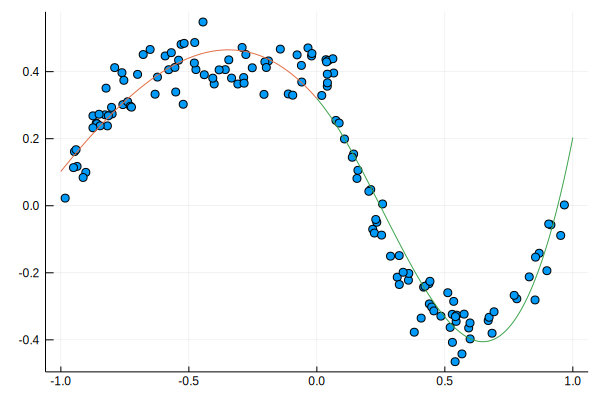

In [3]:
M = 70; N = 2*M;
xleft = rand(M) .- 1; xright = rand(M);
x = [xleft; xright]
y = x.^3 - x + 0.4 ./ (1 .+ 25*x.^2) + 0.05*randn(N);
n = 4;
A = [ vandermonde(xleft,n) zeros(M,n); 
    zeros(M,n) vandermonde(xright,n)]
b = y;
C = [1 zeros(1,n-1) -1 zeros(1,n-1); 
    0 1 zeros(1,n-2) 0 -1 zeros(1,n-2)];
d = zeros(2);
theta = cls_solve(A, b, C, d);
using Plots
# Evaluate and plot for 200 equidistant points on each side.
Npl = 200;
xpl_left = linspace(-1, 0, Npl);
ypl_left = vandermonde(xpl_left, 4)*theta[1:n];
xpl_right = linspace(0, 1, Npl);
ypl_right = vandermonde(xpl_right, 4)*theta[n+1:end];
scatter(x,y, legend=false)
plot!(xpl_left, ypl_left)
plot!(xpl_right, ypl_right)

**Figure 16.1** Least squares fit of two cubic polynomials to $140$ points, with
continuity constraints $p(0) = q(0)$ and $p′(0) = q′(0)$.

**Advertising budget.** We continue the advertising example of page 96 and add a
total budget constraint $1^T s = 1284$.

In [13]:
#Recall from chapter 12:
R = [0.97 1.86 0.41;
    1.23 2.18 0.53;
    0.80 1.24 0.62;
    1.29 0.98 0.51;
    1.10 1.23 0.69;
    0.67 0.34 0.54;
    0.87 0.26 0.62;
    1.10 0.16 0.48;
    1.92 0.22 0.71;
    1.29 0.12 0.62];
m, n = size(R);
vdes = 1e3 * ones(m);

In [14]:
cls_solve(R, vdes, ones(1,n), [1284])

3-element Array{Float64,1}:
 315.16818459234986
 109.86643348012271
 858.9653819275275 

**Minimum norm force sequence.** We compute the smallest sequence of ten forces, each applied for one second to a unit frictionless mass originally at rest, that moves the mass position one with zero velocity (VMLS page [343](https://web.stanford.edu/~boyd/vmls/vmls.pdf#section*.373)). 

In [16]:
A = eye(10); b = zeros(10);
C = [ones(1,10); (9.5:-1:0.5)']

2×10 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 9.5  8.5  7.5  6.5  5.5  4.5  3.5  2.5  1.5  0.5

In [17]:
d = [0,1];
fln = cls_solve(A,b,C,d)

10-element Array{Float64,1}:
  0.05454545454545475  
  0.04242424242424237  
  0.030303030303030096 
  0.0181818181818182   
  0.0060606060606059305
 -0.006060606060606132 
 -0.01818181818181816  
 -0.030303030303030318 
 -0.04242424242424239  
 -0.05454545454545448  

### 16.2 Solution
Let’s implement the function `cls_solve_kkt`, which finds the constrained least squares solution by forming the $KKT$ system and solving it. We allow the `b` and `d` to be matrices, so one function call can solve mutiple problems with the same $A$ and $C$.

In [18]:
function cls_solve_kkt(A,b,C,d)
    m, n = size(A)
    p, n = size(C)
    G = A'*A # Gram matrix
    KKT = [2*G C'; C zeros(p,p)] # KKT matrix; Karush–Kuhn–Tucker
    xzhat = KKT \ [2*A'*b; d]
    return xzhat[1:n,:]
end;
A = randn(10,5); b = randn(10);
C = randn(2,5); d = randn(2);
x = cls_solve_kkt(A,b,C,d);
C*x - d # Check residual small

2×1 Array{Float64,2}:
 -4.440892098500626e-16
 -3.885780586188048e-16

### 16.3 Solving constrained least squares problems
**Solving constrained least squares via QR.** Let’s implement VMLS algorithm [16.1](https://web.stanford.edu/~boyd/vmls/vmls.pdf#algorithmctr.16.1) and then check it against our method above, which forms and solves the $KKT$ system.

```julia
function cls_solve(A,b,C,d)
    m, n = size(A)
    p, n = size(C)
    Q, R = qr([A; C])
    Q = Matrix(Q)
    Q1 = Q[1:m,:]
    Q2 = Q[m+1:m+p,:]
    Qtil, Rtil = qr(Q2')
    Qtil = Matrix(Qtil)
    w = Rtil \ (2*Qtil'*Q1'*b - 2*(Rtil'\d))
    return xhat = R \ (Q1'*b - Q2'*w/2)
end
```

In [20]:
# check with KKT method
m = 10; n = 5; p = 2;
A = randn(m,n); b = randn(m); C = randn(p,n); d = randn(p);
xKKT = cls_solve_kkt(A,b,C,d);
xQR = cls_solve(A,b,C,d);
norm(xKKT-xQR)

5.855045090355223e-16

The function `cls_solve` is included in the `VMLS` package.

**Sparse constrained least squares.** Let’s form and solve the system of linear equations in VMSL ([16.11](https://web.stanford.edu/~boyd/vmls/vmls.pdf#equation.16.3.11)), and compare it to our basic method for constrained least squares. This formulation will result in a sparse set of equations to solve if $A$ and $C$ are sparse. (The code below just checks that the two methods agree; it does not use sparsity. Unlike the earlier `cls_solve`, it assumes `b` and `d` are vectors.)

In [21]:
function cls_solve_sparse(A,b,C,d)
    m, n = size(A)
    p, n = size(C)
    bigA = [ zeros(n,n) A' C';
        A -I/2 zeros(m,p) ;
        C zeros(p,m) zeros(p,p) ]
    xyzhat = bigA \ [zeros(n) ; b ; d]
    return xhat = xyzhat[1:n]
end
m = 100; n = 50; p = 10;
A = randn(m,n); b = randn(m); C = randn(p,n); d = randn(p);
x1 = cls_solve(A,b,C,d);
x2 = cls_solve_sparse(A,b,C,d);
norm(x1-x2)

6.670680158494424e-15

**Solving least norm problem.** In Julia, the backslash operator is used to find the
least norm solution $x̂$ of an under-determined set of equations $Cx = d$. Thus the
backslash operator is overloaded to solve linear equations with a square coefficient
matrix, find a least squares approximate solution when the coefficient matrix is
tall, and find the least norm solution when the coefficient matrix is wide.

Let’s solve a least norm problem using several methods, to check that they
agree.

In [22]:
p = 50; n = 500;
C = randn(p,n); d = randn(p);
x1 = C\d; # Solve using backslash
# Solve using cls_solve, which uses KKT system
x2 = cls_solve(eye(n), zeros(n), C, d);
x3 = pinv(C)*d; # Using pseudo-inverse
norm(x1-x2)

2.274547555887833e-15

In [23]:
norm(x2-x3)

2.3143371247983843e-15